## Binary classification with Logistic regression 

### import libraries 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import pymysql


In [8]:
import getpass
password=getpass.getpass()


········


### connection to sql 

In [9]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine= create_engine(connection_string)

In [27]:
#query
df=pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
DATEDIFF(19981231, convert(a.date,date)) as ageindays, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where l.status in('A','B') and dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, (981231-a.date),
 dp.type, round((l.amount-l.payments)/l.amount,2), ageindays
''', engine)


In [28]:
#query as a df

df.head()

,loan_id,status,nooftrans,ageindays,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid
0,4959,A,374,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96
1,4961,B,259,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92
2,4962,A,225,886,4.09,4.72,OWNER,30276,620209,5623,5887,0.92
3,4973,A,295,1534,1.12,1.54,OWNER,165960,445613,1874,1913,0.96
4,4986,A,209,970,4.75,5.44,OWNER,102876,420128,18782,18347,0.92


In [97]:
#use head to confirm the df works as expected 

### EDA - exploratory data analysis - get to know the data 

In [18]:
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loan_id       234 non-null    int64  
 1   status        234 non-null    object 
 2   nooftrans     234 non-null    int64  
 3   ageofaccount  234 non-null    int64  
 4   95unemp       234 non-null    float64
 5   96unemp       234 non-null    float64
 6   type          234 non-null    object 
 7   loanamount    234 non-null    int64  
 8   birth_number  234 non-null    int64  
 9   crime95       234 non-null    int64  
 10  crime96       234 non-null    int64  
 11  ratiopaid     234 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 22.1+ KB


In [19]:
df.describe()



,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,6233.803419,317.794872,39928.829060,2.867735,3.519487,98143.435897,579128.367521,17469.858974,19639.179487,0.945513
std,680.590147,101.515938,12607.526985,1.986507,2.266641,72013.383242,129120.756354,29906.361998,34746.947993,0.023290
min,4959.000000,108.000000,10602.000000,0.000000,0.430000,4980.000000,350721.000000,0.000000,888.000000,0.920000
25%,5684.750000,228.250000,30406.250000,1.390000,1.960000,45039.000000,465172.000000,2157.500000,2252.000000,0.920000
50%,6300.000000,336.500000,50021.500000,2.790000,3.600000,80646.000000,580767.000000,3804.000000,3894.000000,0.960000
75%,6756.750000,389.500000,50620.750000,4.090000,4.772500,126960.000000,685783.750000,9878.000000,10108.000000,0.960000
max,7308.000000,548.000000,51118.000000,7.340000,9.400000,464520.000000,805709.000000,85677.000000,99107.000000,0.980000


In [20]:
df.dtypes



loan_id           int64
status           object
nooftrans         int64
ageofaccount      int64
95unemp         float64
96unemp         float64
type             object
loanamount        int64
birth_number      int64
crime95           int64
crime96           int64
ratiopaid       float64
dtype: object

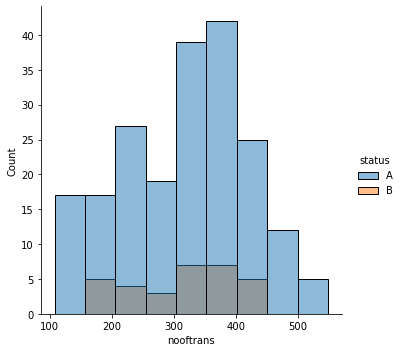

In [24]:
sns.displot(df, x='nooftrans',hue='status')

### histograms or boxplots



<AxesSubplot:xlabel='loanamount', ylabel='status'>

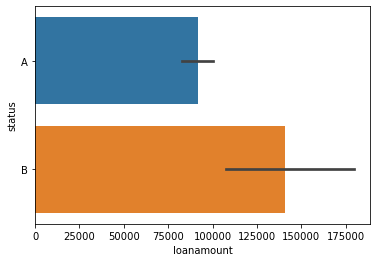

In [25]:
sns.barplot(x='loanamount', y='status', data=df)

### Check for multicollinearity 

In [30]:
correlation=df.corr()
correlation


,loan_id,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
loan_id,1.000000,0.108456,0.077547,-0.083545,-0.078858,0.082673,0.151662,0.144176,0.143709,0.120034
nooftrans,0.108456,1.000000,0.896726,-0.107024,-0.142902,0.200899,0.085988,0.061994,0.062902,0.353508
ageindays,0.077547,0.896726,1.000000,-0.159444,-0.194317,0.278373,0.065923,0.066678,0.067470,0.439152
95unemp,-0.083545,-0.107024,-0.159444,1.000000,0.953504,-0.012914,0.055640,-0.534407,-0.540018,-0.049599
96unemp,-0.078858,-0.142902,-0.194317,0.953504,1.000000,-0.009944,0.041388,-0.568564,-0.572576,-0.050709
loanamount,0.082673,0.200899,0.278373,-0.012914,-0.009944,1.000000,0.008705,-0.007111,-0.005546,0.596621
birth_number,0.151662,0.085988,0.065923,0.055640,0.041388,0.008705,1.000000,-0.019644,-0.019462,0.034583
crime95,0.144176,0.061994,0.066678,-0.534407,-0.568564,-0.007111,-0.019644,1.000000,0.999728,0.018829
crime96,0.143709,0.062902,0.067470,-0.540018,-0.572576,-0.005546,-0.019462,0.999728,1.000000,0.020247
ratiopaid,0.120034,0.353508,0.439152,-0.049599,-0.050709,0.596621,0.034583,0.018829,0.020247,1.000000


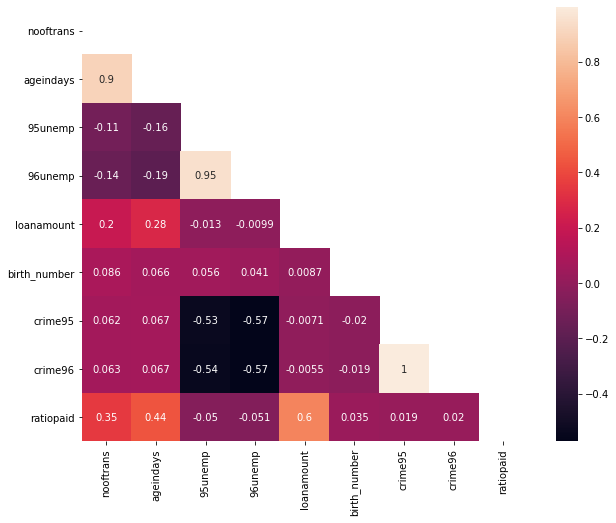

In [40]:
corr_matrix=df.corr(method='pearson')
fig,ax=plt.subplots(figsize=(10,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax=sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()



### Clean and wrangling steps 

In [39]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 

#feature engineering - take the columns and make more useful 

# split the data into num and cat --- > diff options cleaning / scaling 

# check for multicollinearity 


In [32]:
df.drop(['loan_id','type'], axis=1, inplace=True)

In [33]:
df.head()

,status,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,A,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,B,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,A,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,A,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,A,209,970,4.75,5.44,102876,420128,18782,18347,0.92


### Pre processing 

In [96]:
# label / encode categorical columns 

# scale numerical columns 

In [35]:
# cat
cat=df.select_dtypes(include=object)
cat.head()

,status
0,A
1,B
2,A
3,A
4,A


In [38]:
categorical=pd.get_dummies(cat,columns=['status'],drop_first=True)
categorical.head()

,status_B
0,0
1,1
2,0
3,0
4,0


In [41]:
# numerical scaling
from sklearn.preprocessing import Normalizer


In [42]:
select numerical features
x=df.select_dtypes(include=np.number)

In [43]:
x.head()

,nooftrans,ageindays,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
0,374,2134,0.29,0.43,80952,450204,85677,99107,0.96
1,259,1364,1.51,2.07,30276,395423,2299,2354,0.92
2,225,886,4.09,4.72,30276,620209,5623,5887,0.92
3,295,1534,1.12,1.54,165960,445613,1874,1913,0.96
4,209,970,4.75,5.44,102876,420128,18782,18347,0.92


In [60]:
# scaling the numreical features
scaler=Normalizer().fit(x)
scaled=scaler.transform(x)
scaled

array([[7.86012150e-04, 4.48489286e-03, 6.09474662e-07, ...,
        1.80061933e-01, 2.08286915e-01, 2.01757129e-06],
       [6.53056788e-04, 3.43926432e-03, 3.80739672e-06, ...,
        5.79682454e-03, 5.93550456e-03, 2.31973840e-06],
       [3.62317924e-04, 1.42672747e-03, 6.58613471e-06, ...,
        9.05472751e-03, 9.47984720e-03, 1.48147774e-06],
       ...,
       [5.02643230e-04, 2.97351715e-03, 4.27519921e-06, ...,
        2.52004554e-03, 2.56648541e-03, 1.25660808e-06],
       [4.43915356e-04, 2.27378426e-03, 6.97371978e-06, ...,
        3.09422188e-03, 3.01657332e-03, 1.34786181e-06],
       [3.81684646e-04, 1.83646629e-03, 9.02590332e-06, ...,
        5.07452866e-03, 4.81642224e-03, 1.50171008e-06]])

### split off the dependant variable (label)

In [63]:
# y = dependent variable - status
y = categorical['status_B']
x= scaled

In [62]:
y

0      0
1      1
2      0
3      0
4      0
      ..
229    0
230    0
231    0
232    0
233    0
Name: status_B, Length: 234, dtype: uint8

### train test split, get LOG REG model

In [67]:
from sklearn.linear_model import LogisticRegression

In [69]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=40)


## apply model and train model 

In [70]:
classification=LogisticRegression(solver='liblinear', multi_class='ovr').fit(x_train, y_train)

In [ ]:
# add to the parameters 

### evaluate accuracy and test 

In [77]:
probablities=classification.predict_proba(x_test)
preds=probablities[:,1]
import sklearn.metrics as metrics
fpr,tpr, threshold=metrics.roc_curve(y_test, preds)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)

0.7817460317460317


### visualising accuracy - ROC / AUC 

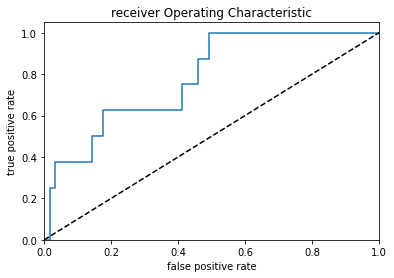

In [79]:
# roc curve plot

plt.title('receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


In [93]:
from sklearn.metrics import accuracy_score
predictions =classification.predict(x_test)

### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix



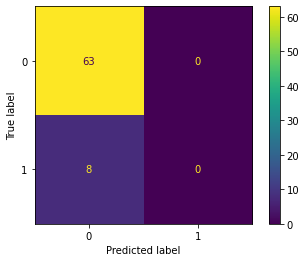

In [95]:
accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification,x_test,y_test)
plt.show()